In [55]:

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from imblearn.over_sampling import SMOTE
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [56]:
data = pd.read_csv('Fish3.txt', delimiter=' ')

X = data.drop('Species', axis=1)
target = data['Species']
print("X.head()" , X.head())
print("target" , target)

X.head()        Weight         L1         L2         L3     Height      Width
1  170.530305  19.323169  22.913269  23.887829  25.233577  14.826372
2  493.721354  28.299621  31.028229  34.917027  37.856243  13.675772
3   33.657735  17.435741  18.072636  23.489747  26.765675  13.660683
4  584.259843  32.491349  33.126297  39.298082  37.610853  13.622560
5  970.375723  37.122510  39.817489  42.473488  29.878001  17.403387
target 1             Perch
2             Bream
3             Roach
4             Bream
5             Perch
           ...     
1862    SilverBream
1863           Pike
1864          Perch
1865    SilverBream
1866          Bream
Name: Species, Length: 1866, dtype: object


In [64]:

classifiers = {
    'RandomForest': RandomForestClassifier(n_estimators=100),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'KNN-3': KNeighborsClassifier(n_neighbors=3),
    'KNN-10': KNeighborsClassifier(n_neighbors=10),
    'SVM-Linear': SVC(kernel='linear', probability=True),
    'SVM-Polynomial': SVC(kernel='poly', degree=3, probability=True)
}

def classify_with_confidence(y_prob, threshold=0.8):
    classifications = []
    for probs in y_prob:
        max_prob = np.max(probs)
        if max_prob >= threshold:
            classifications.append(np.argmax(probs))
        else:
            classifications.append([i for i, p in enumerate(probs) if p >= 1.0/len(probs)])
    return classifications


all_results_all_metrics = []
label_mapping = {label: idx for idx, label in enumerate(target.unique())}

confident_counts = {name: [] for name in classifiers.keys()}

for seed in range(5): 
    X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.3, random_state=seed)
    
    y_train_int = y_train.map(label_mapping)
    y_test_int = y_test.map(label_mapping)
    
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    results_confidence = {}

    for name, clf in classifiers.items():
        pipeline = Pipeline([('SMOTE', SMOTE(random_state=42)), ('Scaler', StandardScaler()), ('Classifier', clf)])
        y_prob = cross_val_predict(pipeline, X_train, y_train_int, cv=cv, method='predict_proba')
        y_pred = classify_with_confidence(y_prob, threshold=0.8)
        max_probs = np.max(y_prob, axis=1)

        confident_classifications = sum(max_probs >= 0.8)
        confident_counts[name].append(confident_classifications)
        
        y_pred_flat = [item if isinstance(item, (int, np.integer)) else item[0] if isinstance(item, list) and len(item) > 0 else -1 for item in y_pred]

        # Remove placeholder values (-1) from y_pred_flat and corresponding entries in y_train_int
        y_pred_flat_filtered = [pred for pred in y_pred_flat if pred != -1]
        y_train_filtered = [true for true, pred in zip(y_train_int, y_pred_flat) if pred != -1]


        y_pred_flat_filtered_str = [list(label_mapping.keys())[list(label_mapping.values()).index(pred)] for pred in y_pred_flat_filtered]
        y_train_filtered_str = [list(label_mapping.keys())[list(label_mapping.values()).index(true)] for true in y_train_filtered]


        report = classification_report(y_train_filtered_str, y_pred_flat_filtered_str, output_dict=True)
        confusion = confusion_matrix(y_train_filtered_str, y_pred_flat_filtered_str, labels=list(label_mapping.keys()))
        
        results_confidence[name] = {
            'accuracy': report["accuracy"],
        }
        
        for class_label in label_mapping.keys():

            results_confidence[name][f'{class_label}_f1'] = report[class_label]["f1-score"]
        
        print(f'{name} Results: {results_confidence[name]}')
        
    all_results_all_metrics.append(results_confidence)


def identify_mislabeled(y_true, y_pred):
    misclassified = np.where(y_true != y_pred)[0]
    return misclassified

pipeline = Pipeline([('SMOTE', SMOTE(random_state=42)), ('Scaler', StandardScaler()), ('Classifier', RandomForestClassifier(n_estimators=100))])
pipeline.fit(X_train, y_train_int)
y_pred = pipeline.predict(X_test)

# Map predictions back to string labels
y_pred_str = [list(label_mapping.keys())[list(label_mapping.values()).index(pred)] for pred in y_pred]
misclassified = identify_mislabeled(y_test, y_pred_str)

print("Misclassified Observations Indices:", misclassified)
print("Misclassified Observations:\n", X_test.iloc[misclassified])

confident_classifications = [1 if isinstance(pred, (int, np.integer)) else 0 for pred in y_pred]
num_confident = sum(confident_classifications)
num_total = len(y_pred)


RandomForest Results: {'accuracy': 0.8705972434915773, 'Perch_f1': 0.7823240589198036, 'Bream_f1': 0.9366459627329192, 'Roach_f1': 0.5315315315315315, 'SilverBream_f1': 0.9487179487179487, 'Pike_f1': 0.9847094801223242, 'Smelt_f1': 0.9793103448275862, 'Whitewish_f1': 0.4888888888888889}
LogisticRegression Results: {'accuracy': 0.8560490045941807, 'Perch_f1': 0.7625201938610663, 'Bream_f1': 0.9455864570737605, 'Roach_f1': 0.48148148148148145, 'SilverBream_f1': 0.9281045751633987, 'Pike_f1': 0.9847094801223242, 'Smelt_f1': 0.9577464788732394, 'Whitewish_f1': 0.0}
KNN-3 Results: {'accuracy': 0.8981623277182236, 'Perch_f1': 0.825, 'Bream_f1': 0.9351969504447268, 'Roach_f1': 0.7045454545454546, 'SilverBream_f1': 0.9659442724458205, 'Pike_f1': 0.9847094801223242, 'Smelt_f1': 0.9829351535836177, 'Whitewish_f1': 0.6896551724137931}
KNN-10 Results: {'accuracy': 0.9111791730474732, 'Perch_f1': 0.8327137546468402, 'Bream_f1': 0.9577114427860697, 'Roach_f1': 0.7169811320754716, 'SilverBream_f1': 0

RandomForest: 982 observations classified with confidence.
LogisticRegression: 734 observations classified with confidence.
KNN-3: 1077 observations classified with confidence.
KNN-10: 1105 observations classified with confidence.
SVM-Linear: 788 observations classified with confidence.
SVM-Polynomial: 857 observations classified with confidence.


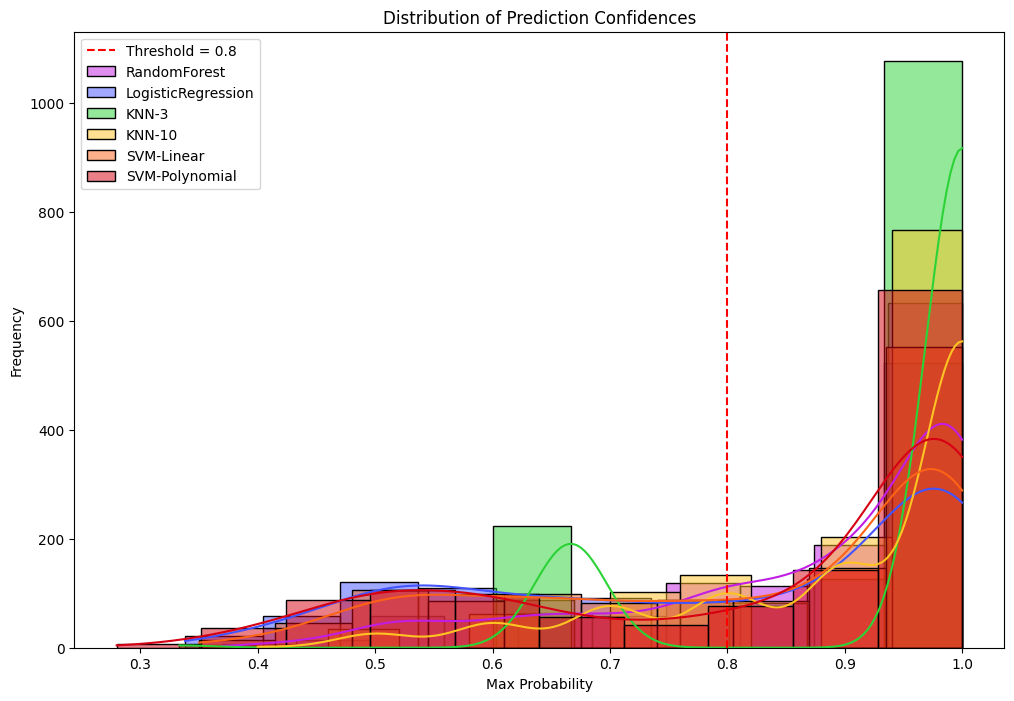

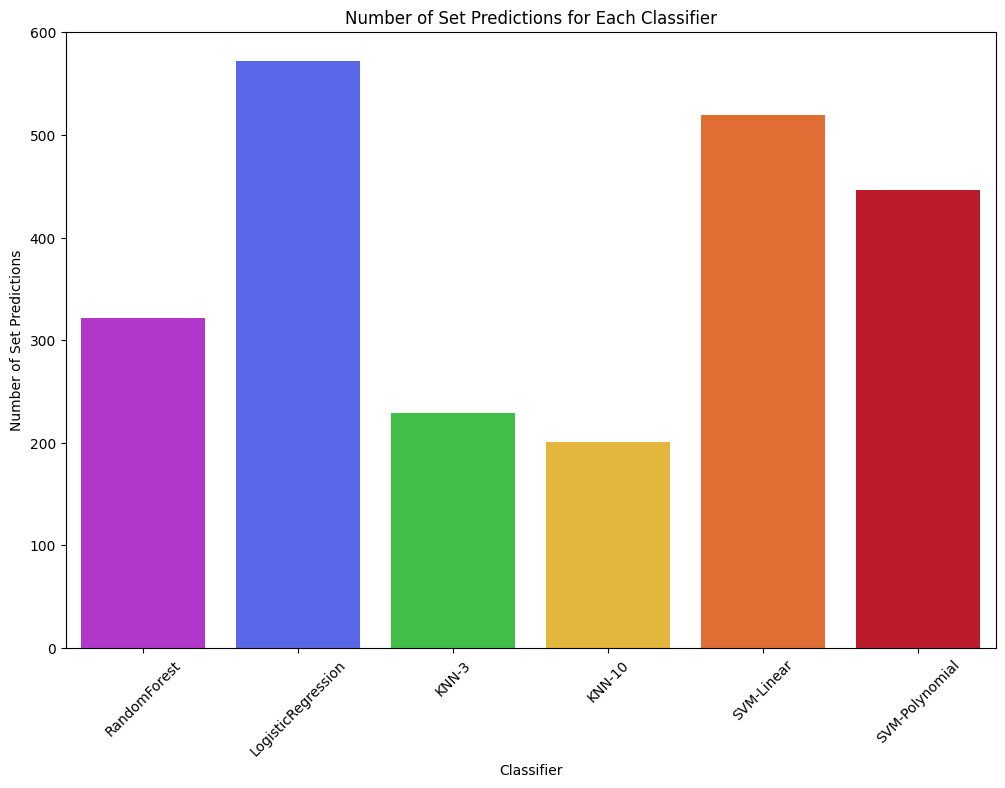

In [81]:

import seaborn as sns

colors = ['#C21DE3', '#4354FF','#2BD336', '#FFC322','#FD6317',  '#D60013']
def plot_confidence_distribution(classifiers, X_train, y_train_int, cv, threshold=0.8):
    plt.figure(figsize=(12, 8))
    
    for i ,(name, clf) in enumerate(classifiers.items()):
        pipeline = Pipeline([('SMOTE', SMOTE(random_state=42)), ('Scaler', StandardScaler()), ('Classifier', clf)])
        y_prob = cross_val_predict(pipeline, X_train, y_train_int, cv=cv, method='predict_proba')
        max_probs = np.max(y_prob, axis=1)
        
        sns.histplot(max_probs, bins=10, kde=True, label=name, alpha=0.5, color=colors[i % len(colors)])

        confident_classifications = sum(max_probs >= 0.8)
        print(f"{name}: {confident_classifications} observations classified with confidence.")
    
        
    plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
    plt.title('Distribution of Prediction Confidences')
    plt.xlabel('Max Probability')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Usage:
plot_confidence_distribution(classifiers, X_train, y_train_int, cv, threshold=0.8)

#This plot will show the number of set predictions (low-confidence predictions) for each classifier.
def plot_set_predictions(classifiers, X_train, y_train_int, cv, threshold=0.8):
    set_prediction_counts = []
    classifier_names = []

    for name, clf in classifiers.items():
        pipeline = Pipeline([('SMOTE', SMOTE(random_state=42)), ('Scaler', StandardScaler()), ('Classifier', clf)])
        y_prob = cross_val_predict(pipeline, X_train, y_train_int, cv=cv, method='predict_proba')
        y_pred = classify_with_confidence(y_prob, threshold=threshold)
        set_predictions = sum([1 for pred in y_pred if isinstance(pred, list)])
        
        set_prediction_counts.append(set_predictions)
        classifier_names.append(name)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x=classifier_names, y=set_prediction_counts, palette=colors)
    plt.title('Number of Set Predictions for Each Classifier')
    plt.xlabel('Classifier')
    plt.ylabel('Number of Set Predictions')
    plt.xticks(rotation=45)
    plt.show()

# Usage:
plot_set_predictions(classifiers, X_train, y_train_int, cv, threshold=0.8)

In [78]:
def plot_confidence_distribution(classifiers, X_train, y_train_int, cv, threshold=0.8):
    colors = ['#C21DE3', '#4354FF','#2BD336', '#FFC322','#FD6317',  '#D60013']
    plt.figure(figsize=(12, 8))
    
    for i, (name, clf) in enumerate(classifiers.items()):
        pipeline = Pipeline([('SMOTE', SMOTE(random_state=42)), ('Scaler', StandardScaler()), ('Classifier', clf)])
        y_prob = cross_val_predict(pipeline, X_train, y_train_int, cv=cv, method='predict_proba')
        max_probs = np.max(y_prob, axis=1)
        
        sns.histplot(max_probs, bins=10, kde=True, label=name, color=colors[i % len(colors)], alpha=0.5)

        confident_classifications = sum(max_probs >= 0.8)
        print(f"{name}: {confident_classifications} observations classified with confidence.")
    
    plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
    plt.title('Distribution of Prediction Confidences')
    plt.xlabel('Max Probability')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

colors = ['#C21DE3', '#4354FF','#2BD336', '#FFC322','#FD6317',  '#D60013']
def plot_set_predictions(classifiers, X_train, y_train_int, cv, threshold=0.8):
    set_prediction_counts = []
    classifier_names = []

    for name, clf in classifiers.items():
        pipeline = Pipeline([('SMOTE', SMOTE(random_state=42)), ('Scaler', StandardScaler()), ('Classifier', clf)])
        y_prob = cross_val_predict(pipeline, X_train, y_train_int, cv=cv, method='predict_proba')
        y_pred = classify_with_confidence(y_prob, threshold=threshold)
        set_predictions = sum([1 for pred in y_pred if isinstance(pred, list)])
        
        set_prediction_counts.append(set_predictions)
        classifier_names.append(name)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x=classifier_names, y=set_prediction_counts, palette=colors)
    plt.title('Number of Set Predictions for Each Classifier')
    plt.xlabel('Classifier')
    plt.ylabel('Number of Set Predictions')
    plt.xticks(rotation=45)
    plt.show()

In [66]:
aggregated_results = {}
for result in all_results_all_metrics:
    for clf, metrics in result.items():
        if clf not in aggregated_results:
            aggregated_results[clf] = {'accuracy': [], 'confident_classifications': []}
            for class_label in metrics.keys():
                if class_label != 'accuracy':
                    aggregated_results[clf][class_label] = []
        
        aggregated_results[clf]['accuracy'].append(metrics['accuracy'])
        for class_label, f1_score in metrics.items():
            if class_label != 'accuracy' and class_label != 'confident_classifications':
                aggregated_results[clf][class_label].append(f1_score)

# Calculate mean values
mean_results = {}
for clf, metrics in aggregated_results.items():
    mean_results[clf] = {
        'accuracy': np.mean(metrics['accuracy']),
        'confident_classifications': np.mean(confident_counts[clf])
         }
    for class_label, scores in metrics.items():
        if class_label != 'accuracy' and class_label != 'confident_classifications':
            mean_results[clf][class_label] = np.mean(scores)

# Display the results in a table
mean_results_df = pd.DataFrame(mean_results).T
mean_results_df



,accuracy,confident_classifications,Perch_f1,Bream_f1,Roach_f1,SilverBream_f1,Pike_f1,Smelt_f1,Whitewish_f1
RandomForest,0.877489,971.4,0.792822,0.934956,0.573921,0.954516,0.983924,0.980088,0.435383
LogisticRegression,0.853292,744.6,0.770148,0.935970,0.454184,0.913088,0.983924,0.955004,0.000000
KNN-3,0.890965,1085.6,0.805312,0.910826,0.721621,0.971962,0.983924,0.982931,0.766267
KNN-10,0.912711,1089.4,0.839602,0.948454,0.739777,0.979110,0.983924,0.982924,0.763498
SVM-Linear,0.853446,796.8,0.775203,0.934373,0.434996,0.908117,0.983924,0.959391,0.049766
SVM-Polynomial,0.828025,858.4,0.735977,0.918544,0.293304,0.910229,0.982762,0.954232,0.233899


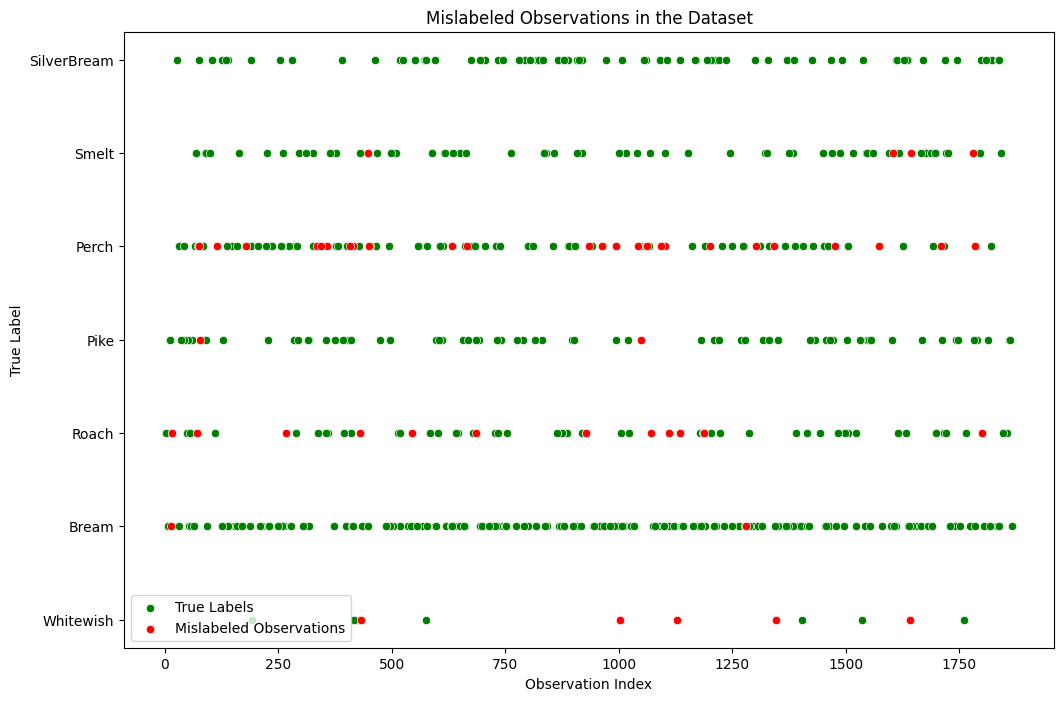

In [72]:
def plot_mislabeled_observations(classifier, X_train, X_test, y_train_int, y_test, label_mapping):
    pipeline = Pipeline([('SMOTE', SMOTE(random_state=42)), ('Scaler', StandardScaler()), ('Classifier', classifier)])
    pipeline.fit(X_train, y_train_int)
    y_pred = pipeline.predict(X_test)
    
    y_pred_str = [list(label_mapping.keys())[list(label_mapping.values()).index(pred)] for pred in y_pred]
    misclassified = identify_mislabeled(y_test, y_pred_str)

    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=X_test.index, y=y_test, color='green', label='True Labels')
    sns.scatterplot(x=X_test.index[misclassified], y=y_test.iloc[misclassified], color='red', label='Mislabeled Observations')
    
    plt.title('Mislabeled Observations in the Dataset')
    plt.xlabel('Observation Index')
    plt.ylabel('True Label')
    plt.legend()
    plt.show()

# Usage:
plot_mislabeled_observations(RandomForestClassifier(n_estimators=100), X_train, X_test, y_train_int, y_test, label_mapping)
